# Zombie modelling

TO DO:
* Fix SIR model equations to account for fixed population
* Work out map projection so it looks normal
* Calculate population over time graphs more efficiently by applying a single mask over entire array
* Include diagonal interaction terms 
* Experiment with beta and gamma parameters to reduce required computation time


In [1]:
# Import dependencies

import os
import glob
import matplotlib.pyplot as plt
import numpy as np

import rasterio
from rasterio.plot import show
import imageio

from tqdm import tqdm

import rioxarray

## Format population density map
The data is a map of the population density of a given country in 2020, at a resolution of approximately 1km^2 per pixel. 

In [2]:
# The population density map is at the following location
file = 'Data/PopDensity/Germany/2020/deu_pd_2020_1km_UNadj.tif'
#file = 'Data/PopDensity/Czechia/2020/cze_pd_2020_1km_UNadj.tif'
country = 'Germany'
#country = 'Czechia'

with rasterio.open(file) as src:
    full_img = src.read()
    band = src.read(1)
    meta = src.meta
    transform = src.transform
    crs = src.crs
    mask = np.array(src.read_masks(1)/255, dtype=bool)
    
# Create a copy of the band with the masked values represented with 0 instead of -99999.0
band0 = np.where(band <0, 0, band)

In [3]:
print(f'The shape of the image is {band.shape}')
print(f'The shape of the mask is {mask.shape}')
print(f'The mask is represented in the image by pixels with a value of {meta["nodata"]}')
aspect_ratio = band.shape[1]/band.shape[0]
print(f'The aspect ratio is {aspect_ratio}')
print(f'The coordinate reference system (CRS) is {crs}')

The shape of the image is (934, 1100)
The shape of the mask is (934, 1100)
The mask is represented in the image by pixels with a value of -99999.0
The aspect ratio is 1.177730192719486
The coordinate reference system (CRS) is EPSG:4326


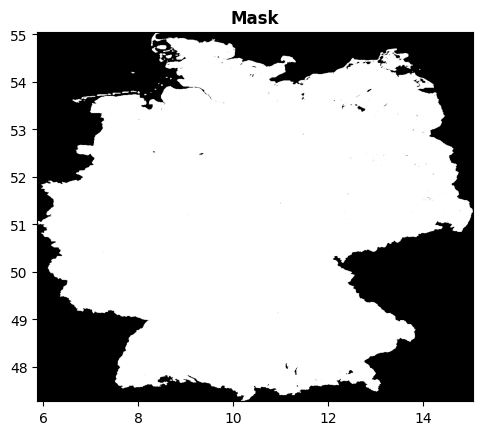

In [4]:
# The mask is an array where the pixels for which we have data are white (True), and the pixels for which we do not have data are black (False)
show(mask,transform=transform, title='Mask', cmap='Greys_r')

plt.show()

In [5]:
# We can apply the mask to our data to obtain only the parts for which we have data (we need to invert the mask because we are 'masking away' the bad stuff
masked_band = np.ma.masked_array(band, ~mask)

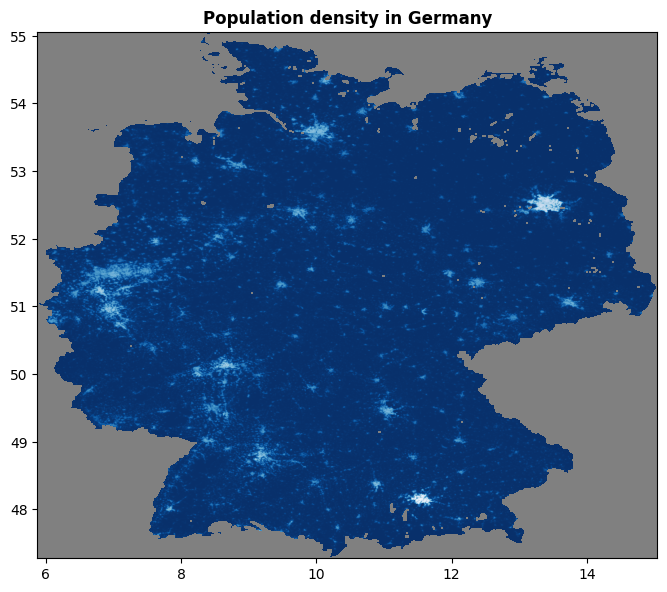

In [6]:
# Let's visualise this data now

cmap = plt.cm.get_cmap("Blues_r").copy()
cmap.set_bad(color='grey')


fig, ax = plt.subplots(figsize=(8,8))
show(masked_band, transform=transform, title=f'Population density in {country}', cmap=cmap)
plt.show()



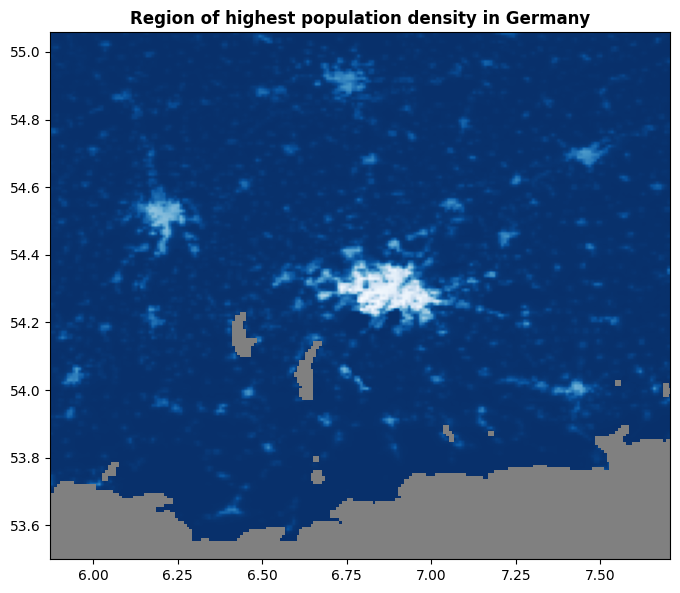

In [7]:
# Zooming in on the highest population density, we see
fig, ax = plt.subplots(figsize=(8,8))

# Finds the index of the highest population density
max_idx = np.unravel_index(masked_band.argmax(), masked_band.shape)

# Plots the region around the area with the highest population density
show(masked_band[int(np.floor(max_idx[0] - 0.1*band.shape[0])):int(np.floor(max_idx[0] + 0.1*band.shape[0])), int(np.floor(max_idx[1] - 0.1*band.shape[1])): int(np.floor(max_idx[1] + 0.1*band.shape[1]))], transform=transform,  title=f'Region of highest population density in {country}', cmap=cmap)
plt.show()

In [8]:
# By taking the mean of the masked_band array, we get the population density across germany. Multiplying this by area should net the total population.
mean_pop_dens = masked_band.mean() #in people per square kilometer
total_area = (~mask).sum()  # in square kilometers (average only)

total_population = mean_pop_dens*total_area 
print(f'The population of {country} is approximately {total_population/1000000:.1f} million people')



The population of Germany is approximately 85.6 million people


## The SIR model
The SIR model is the simplest mathematical model to describe disease spread, and involves dividing the population into three separate groups:
* Susceptible ($S$) - The healthy members of the population
* Infected ($I$) - The zombie members of the population
* Removed ($R$) - The zombies who have been killed



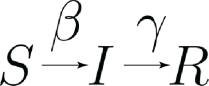
    
    
At any given time the zombies have the potential to infect members of the healthy group. The details of how the disease spreads is a complicated topic, but on average we can describe the rate of transmission with a single number, the infection rate parameter $\beta$. Bigger $\beta$ means a more infectious disease. The number of new infected at each step is proportional to this parameter $\beta$, the number of current zombies (more zombies = more bites), as well as the current number of healthy individuals nearby (high population density means diseases spread more quickly). Similarly, the rate of removal is described with a single number, $\gamma$, which describes the rate at which zombies are killed (we assume there is no cure). 

The number of individuals in each of the three parts of the population is therefore described by the following set of differential equations:

$\frac{dS}{dt} = -\beta IS$

$\frac{dI}{dt} = \beta IS - \gamma I $

$\frac{dR}{dt} = \gamma I$

This model assumes that the entire population interacts all the time, which might be true if they were all in the same restaurant or on a bus, but in reality people interact with the people that are near them and not on the other side of the country. To put this into our model we will divide our country into a grid and assign an SIR split to each point on the grid. We then assume that each gridpoint can be infected (and infect) the gridpoints around it. That is, if we have a gridpoint at some coordinates $(i,j)$, then the equations for that coordinate are:

$\frac{dS_{i,j}}{dt} = -\beta (I_{i-1,j} S_{i-1,j} + I_{i+1,j}S_{i+1,j} + I_{i,j-1} S_{i, j-1} + I_{i, j+1}, S_{i,j+1})$

with a similar term for $I$. We could also include diagonal interactions here, but for simplicity of exposition we will leave these out.

### How does the population density map come into this?
We will use the population density map obtained at the start of this notebook as our initial values for the susceptible population. Each pixel is a gridpoint, and the brightness of that pixel represents the population density, and actually the total population at each pixel. We will assume that almost all of the population is initially uninfected (and therefore susceptible), and numerically solve the above equations when we introduce a small infected population into the most densely populated part of the country. 

In [9]:
#Define beta and gamma 
beta = 0.001
gamma = 0.01



By rearranging the definition of the derivative, we have

$u_{n+1} = f(u) \Delta t + u_n$

where $u'(t) = f(u)$

In [10]:
# This step calculates the next step from the previous one, we just need to implement u and f
# We also clip the values here so they don't go above the maximum or below the minimum
def euler_step(u, f, dt):
    newu = u + dt * f(u)
    
    # Set anything below 0 to 0
#    newu[0] = np.where(newu[0]<0, 0, newu[0])
#    newu[1] = np.where(newu[1]<0, 0, newu[1])
#    newu[2] = np.where(newu[2]<0, 0, newu[2])    
    
    # Now set anything above max to max
#    newu[0] = np.where(newu[0]>band0, np.maximum(newu[0], band0), newu[0])
#    newu[1] = np.where(newu[1]>band0, np.maximum(newu[1], band0), newu[1])
#    newu[2] = np.where(newu[2]>band0, np.maximum(newu[2], band0), newu[2])
    
    
    
    
    return newu


In [11]:
# f, the function which controls the RHS of the derivative, will be given by
def f(u):
    S = u[0]
    I = u[1]
    R = u[2]
    
    
    new = np.array([-beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]),
                     beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]) - gamma*I[1:-1, 1:-1],
                     gamma*I[1:-1, 1:-1]
                    ])
    
    # Here we want to apply the mask, and clip any populations that go below zero to be zero
    # We also want to clip any populations which go above the population in that pixel to the max
    padding = np.zeros_like(u)
    padding[:,1:-1,1:-1] = new
    
    # First apply the mask to each layer
    padding[0] = np.ma.masked_array(padding[0], ~mask)
    padding[1] = np.ma.masked_array(padding[1], ~mask)
    padding[2] = np.ma.masked_array(padding[2], ~mask)
    

    
    return padding


In [12]:
# Set the number of timesteps you want
T = 100                          # final time
dt = 1                          # time increment
N = int(T/dt) + 1               # number of time-steps
t = np.linspace(0.0, T, N)      # time discretization

# u will be a multi-dimensional array consisting of the S,I, and R values at each gridpoint and each time
u = np.zeros((N, 3, band.shape[0], band.shape[1]))


$ S_{i,j}(t) = u[t, 0, i, j]$

$ I_{i,j}(t) =  u[t, 1, i, j]$

$ R_{i,j}(t) =  u[t, 2, i, j]$

In [13]:
# The initial susceptible population is just the population density
u[0, 0, :,:] = masked_band

# We need to set the masked data to zero (masked data was originally -9999)
u[0,0][u[0,0]<0] = 0

# The initial infected population is mostly zero
# However we will inject a "patient zero" at the most densely populated part of the country
u[0, 1, max_idx[0], max_idx[1]] = 1

# The removed part of the population is initially zero

In [14]:
# Run the code
for n in tqdm(range(N-1)):
    u[n+1] = euler_step(u[n], f, dt)

 10%|█         | 10/100 [00:00<00:06, 13.10it/s]C:\Users\Mark\AppData\Local\Temp\ipykernel_12644\204355951.py:8: RuntimeWarning: overflow encountered in multiply
  new = np.array([-beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
C:\Users\Mark\AppData\Local\Temp\ipykernel_12644\204355951.py:9: RuntimeWarning: overflow encountered in multiply
  S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
C:\Users\Mark\AppData\Local\Temp\ipykernel_12644\204355951.py:10: RuntimeWarning: overflow encountered in multiply
  S[2:, 1:-1]*I[2:, 1:-1] + \
C:\Users\Mark\AppData\Local\Temp\ipykernel_12644\204355951.py:11: RuntimeWarning: overflow encountered in multiply
  S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
C:\Users\Mark\AppData\Local\Temp\ipykernel_12644\204355951.py:12: RuntimeWarning: overflow encountered in multiply
  S[1:-1, 2:]*I[1:-1, 2:]),
C:\Users\Mark\AppData\Local\Temp\ipykernel_12644\204355951.py:13: RuntimeWarning: overflow encountered in multiply
  beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
C:\Users\Mark\AppData\Local\Temp\ipykerne

In [15]:
uRGB = np.transpose(u, (0,2,3,1))
# We want the infected to be red, the healthy to be green, and the dead to be blue
uRGB[:,:,:,[1,0]] = uRGB[:,:,:,[0,1]]


# Rescale all elements so they are between 0 and 1
uRGB = uRGB/uRGB.max()



D:\Anaconda\envs\Zombies\lib\site-packages\matplotlib\cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


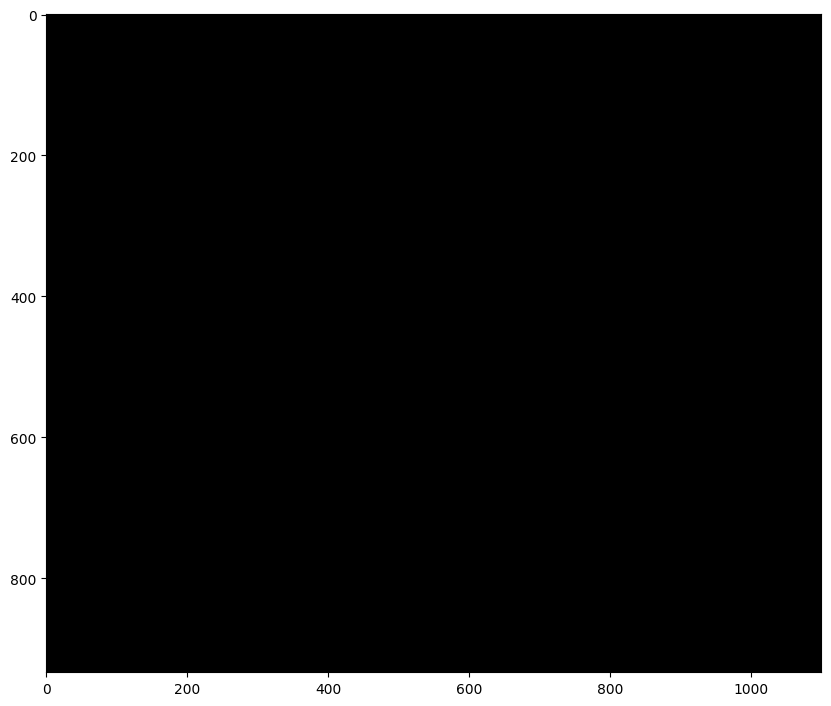

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(np.clip(uRGB[0, :, :, :]*40,0,1),    # display first slice              
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1)
plt.savefig('1.png')
plt.show()

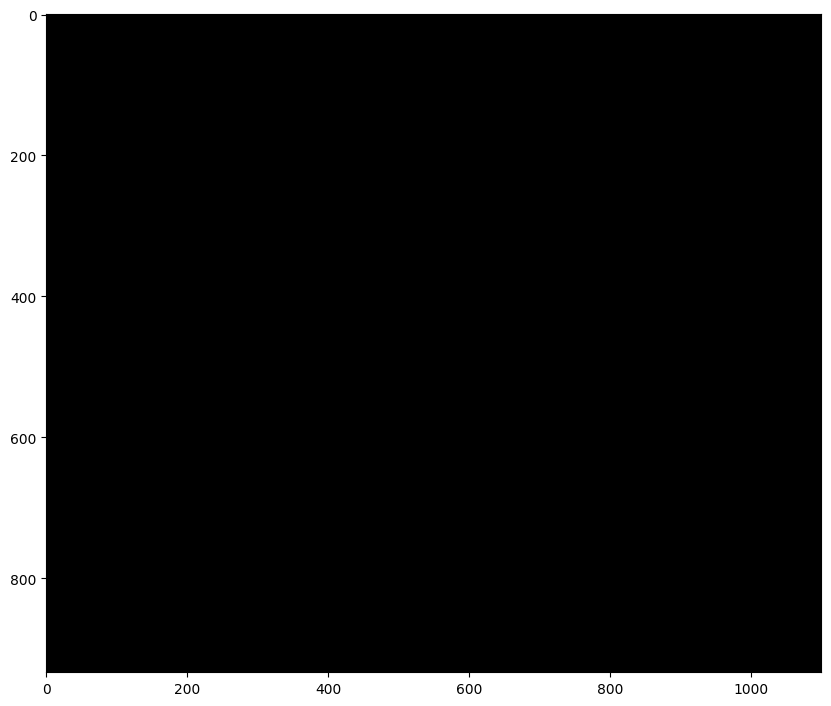

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(np.clip(uRGB[N-1, :, :, :]*40,0,1),    # display first slice              
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1)

plt.savefig('2.png')
plt.show()

In [18]:
health_pop = [np.ma.masked_array(u[t,0], ~mask).mean()*total_area/1000000 for t in range(N-1)]
zombie_pop = [np.ma.masked_array(u[t,1], ~mask).mean()*total_area/1000000 for t in range(N-1)]
dead_pop = [np.ma.masked_array(u[t,2], ~mask).mean()*total_area/1000000 for t in range(N-1)]

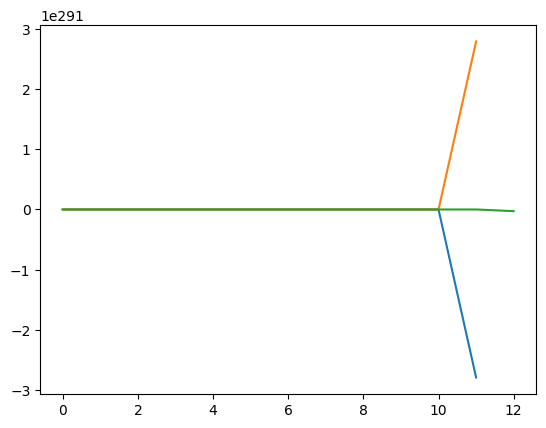

In [19]:
plt.plot(health_pop)
plt.plot(zombie_pop)
plt.plot(dead_pop)

plt.show()

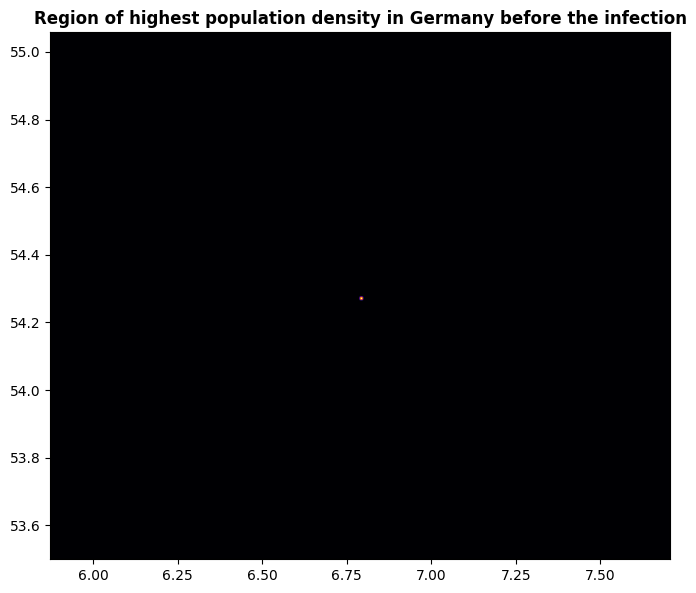

In [20]:
# Zooming in on the highest population density, we see
fig, ax = plt.subplots(figsize=(8,8))

# Finds the index of the highest population density
max_idx = np.unravel_index(masked_band.argmax(), masked_band.shape)

# Plots the region around the area with the highest population density
show(u[0,0][int(np.floor(max_idx[0] - 0.1*band.shape[0])):int(np.floor(max_idx[0] + 0.1*band.shape[0])), int(np.floor(max_idx[1] - 0.1*band.shape[1])): int(np.floor(max_idx[1] + 0.1*band.shape[1]))], transform=transform,  title=f'Region of highest population density in {country} before the infection', cmap="inferno")
plt.show()

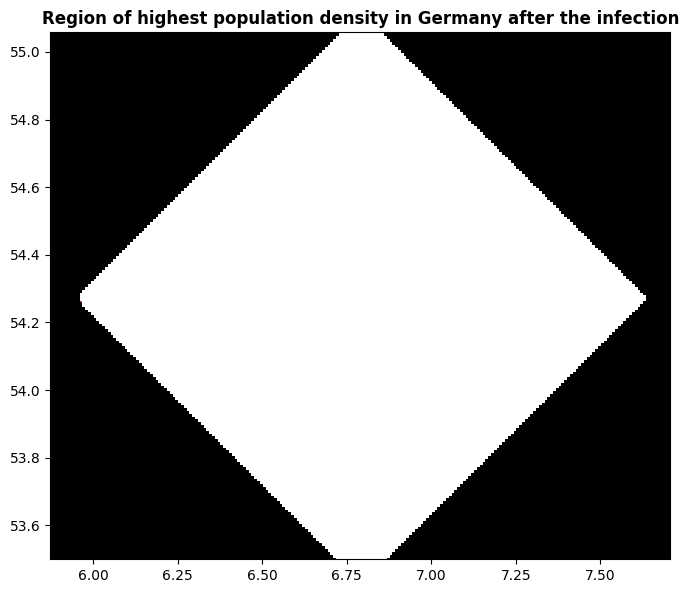

In [21]:
# Zooming in on the highest population density, we see
fig, ax = plt.subplots(figsize=(8,8))

# Finds the index of the highest population density
max_idx = np.unravel_index(masked_band.argmax(), masked_band.shape)

# Plots the region around the area with the highest population density
show(u[N-1,0][int(np.floor(max_idx[0] - 0.1*band.shape[0])):int(np.floor(max_idx[0] + 0.1*band.shape[0])), int(np.floor(max_idx[1] - 0.1*band.shape[1])): int(np.floor(max_idx[1] + 0.1*band.shape[1]))], transform=transform,  title=f'Region of highest population density in {country} after the infection', cmap="inferno")
plt.show()

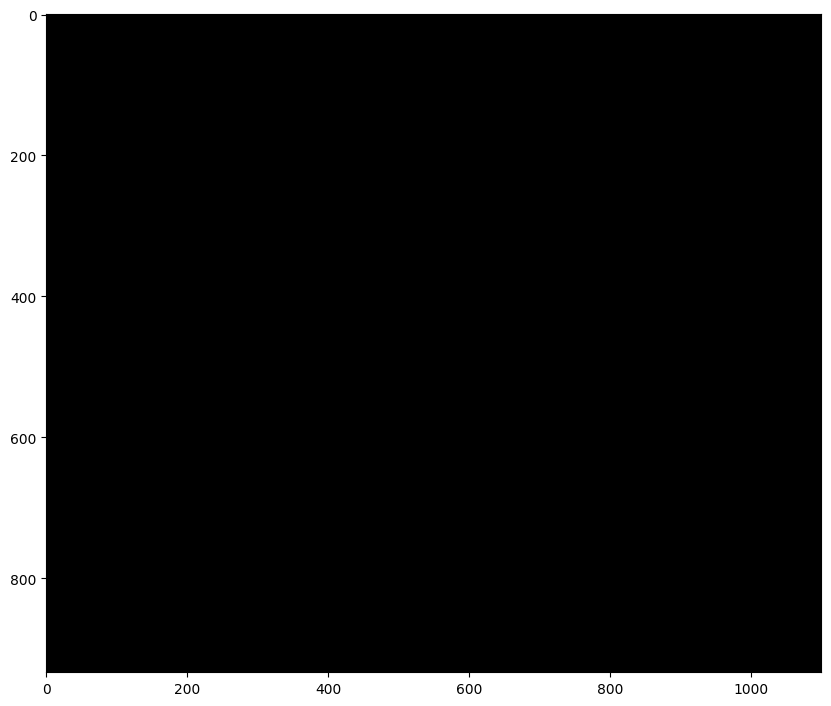

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(np.clip(uRGB[0, :, :, :]*40,0,1),    # display first slice              
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1)

D:\Anaconda\envs\Zombies\lib\site-packages\matplotlib\cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


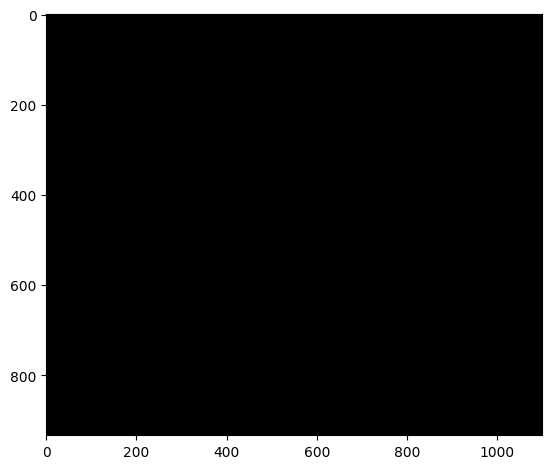

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation


# generating gif out of slices of 4-dimensional numpy array
def generate_gif(numpy_array):
    
#    fig = plt.subplots(figsize=(10,10)
    fig = plt.figure()
    im = plt.imshow(np.clip(numpy_array[0, :, :, :]*40,0,1),    # display first slice      
                    animated=True,
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1)

#    im = plt.imshow(numpy_array[0, :, :, :],    # display first slice
#                    animated=True,
#                    cmap='Reds_r',               # color mapping
#                    vmin=np.iinfo('uint8').min, # lowest value in numpy_3d_array
#                    vmax=np.iinfo('uint8').max) # highest value in numpy_3d_array
#    if channel==0:
#        plt.colorbar(label='Healthy', shrink=0.75)
#    elif channel==1:
#        plt.colorbar(label='Infected', shrink=0.75)
#    else:
#        plt.colorbar(label='Dead', shrink=0.75)

        
    
    plt.tight_layout()

    def init():
        im.set_data(np.clip(numpy_array[0, :, :, :]*40,0,1))
        return im,

    def animate(i):
        im.set_array(np.clip(numpy_array[i, :, :, :]*40,0,1))
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=range(0, np.shape(numpy_array)[0], 5),  # amount of frames being animated
                                   interval=1,                       # Delay between frames in milliseconds.
                                   blit=True,
                                   repeat_delay=1000)        #How long to wait before restarting the gif in milliseconds
    anim.save("RGB.gif")   # save as gif
    plt.show()
generate_gif(uRGB)